In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')
tagged_sentence = nltk.corpus.treebank.tagged_sents(tagset='universal')
print("Number of Tagged Sentences ",len(tagged_sentence))

[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
Number of Tagged Sentences  3914


In [ ]:
def word_to_ix(word, ix):
    return torch.tensor(ix[word], dtype = torch.long)

def char_to_ix(char, ix):
    return torch.tensor(ix[char], dtype= torch.long)

def tag_to_ix(tag, ix):
    return torch.tensor(ix[tag], dtype= torch.long)

def sequence_to_idx(sequence, ix):
    return torch.tensor([ix[s] for s in sequence], dtype=torch.long)


word_to_idx = {}
tag_to_idx = {}
char_to_idx = {}
for sentence in tagged_sentence:
    for word, pos_tag in sentence:
        if word not in word_to_idx.keys():
            word_to_idx[word] = len(word_to_idx)
        if pos_tag not in tag_to_idx.keys():
            tag_to_idx[pos_tag] = len(tag_to_idx)
        for char in word:
            if char not in char_to_idx.keys():
                char_to_idx[char] = len(char_to_idx)

In [ ]:
word_vocab_size = len(word_to_idx)
tag_vocab_size = len(tag_to_idx)
char_vocab_size = len(char_to_idx)

print("Unique words: {}".format(len(word_to_idx)))
print("Unique tags: {}".format(len(tag_to_idx)))
print("Unique characters: {}".format(len(char_to_idx)))

Unique words: 12408
Unique tags: 12
Unique characters: 79


In [ ]:
from sklearn.model_selection import train_test_split


test_size_p = 0.15
validation_size_p = 0.15

test_size= int(len(tagged_sentence) * test_size_p)
validation_size_p= int(len(tagged_sentence) * validation_size_p)

#Splitting into training, test and validation : 
train_set, test_set = train_test_split(tagged_sentence,test_size=test_size,random_state = 42)
train_set, validation_set = train_test_split(train_set,test_size=validation_size_p,random_state = 42)

#Get length of training, test and validation set : 
print(len(train_set))
print(len(test_set))
print(len(validation_set))

2740
587
587


Parameter : 

In [ ]:
WORD_EMBEDDING_DIM = 1024
WORD_HIDDEN_DIM = 256
EPOCHS = 10

In [ ]:


class LSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, target_size):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        
        self.hidden2tag = nn.Linear(hidden_dim, target_size)
        
    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores




In [ ]:
model = LSTM(WORD_EMBEDDING_DIM, WORD_HIDDEN_DIM, word_vocab_size,tag_vocab_size)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

if use_cuda:
  print("Cuda:")
  model.cuda()


loss_function = nn.CrossEntropyLoss()

optimizer = optim.Adamax(model.parameters(), lr=0.001,weight_decay=0.0003)


Cuda:


In [ ]:
train_loss_list = []
val_loss_list = []
train_acc_list =[]
val_acc_list =[]
for epoch in range(EPOCHS):
  
  train_loss =0 
  train_acc = 0

  val_acc = 0
  val_loss = 0


  for sentence_tag in train_set:
    
    model.zero_grad()


    sentence = [s[0] for s in sentence_tag]
    sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
    targets = [s[1] for s in sentence_tag]
    targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)


    
    tag_scores = model(sentence)
    
    loss = loss_function(tag_scores, targets)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()


    _, indices = torch.max(tag_scores, 1)
    train_acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))

  train_loss_list.append(train_loss/len(training_data))
  train_acc_list.append(float(train_acc/len(training_data)))

  for sentence_tag in validation_set:


    sentence = [s[0] for s in sentence_tag]
    sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
    targets = [s[1] for s in sentence_tag]
    targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)



    tag_scores = model(sentence)
    
    loss = loss_function(tag_scores, targets)
    val_loss += loss.item()
    _, indices = torch.max(tag_scores, 1)
    val_acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))
  val_loss_list.append(val_loss/len(valiation_data))
  val_acc_list.append(float(val_acc/len(valiation_data)))
  print("Epoch: ", epoch +1," val loss: ",val_loss/len(valiation_data), " val acc: ", float(val_acc/len(valiation_data)),
        " train loss : ", train_loss/len(training_data)," train acc: ",float(train_acc/len(training_data)))





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch:  1  val loss:  0.4383801594249638  val acc:  0.8687277436256409  train loss :  0.6528365041516776  train acc:  0.8179853558540344
Epoch:  2  val loss:  0.3217066267927318  val acc:  0.9031838774681091  train loss :  0.35493290030744173  train acc:  0.8948508501052856
Epoch:  3  val loss:  0.26776681927998996  val acc:  0.9176445007324219  train loss :  0.25397128083532416  train acc:  0.9241659045219421
Epoch:  4  val loss:  0.24044152502497274  val acc:  0.9258592128753662  train loss :  0.19716550259626586  train acc:  0.9421391487121582
Epoch:  5  val loss:  0.2262581114949154  val acc:  0.9314910769462585  train loss :  0.16069113097874188  train acc:  0.9534524083137512
Epoch:  6  val loss:  0.21890266606777753  val acc:  0.934453547000885  train loss :  0.13584009329499472  train acc:  0.9629897475242615
Epoch:  7  val loss:  0.21573407828785618  val acc:  0.9368259906768799  train loss :  0.11884446711700926  train acc:  0.9691824913024902
Epoch:  8  val loss:  0.21384430

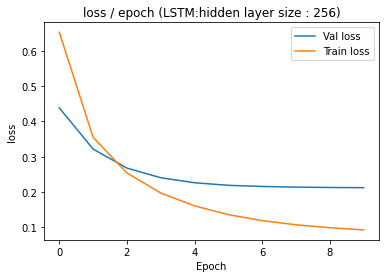

In [ ]:
import matplotlib.pyplot as plt


plt.plot(val_loss_list,label="Val loss")
plt.plot(train_loss_list,label="Train loss")

plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.title("loss / epoch (LSTM:hidden layer size : 256)")
plt.show()

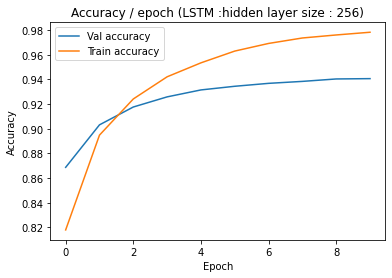

In [ ]:
import matplotlib.pyplot as plt


plt.plot(val_acc_list,label="Val accuracy")
plt.plot(train_acc_list,label="Train accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy / epoch (LSTM :hidden layer size : 256)")
plt.show()

In [ ]:
test_acc = 0 
for sentence_tag in test_set:


  sentence = [s[0] for s in sentence_tag]
  sentence = torch.tensor(sequence_to_idx(sentence, word_to_idx), dtype=torch.long).to(device)
  targets = [s[1] for s in sentence_tag]
  targets = torch.tensor(sequence_to_idx(targets, tag_to_idx), dtype=torch.long).to(device)



  tag_scores = model(sentence)
  _, indices = torch.max(tag_scores, 1)
  test_acc += torch.mean(torch.tensor(targets == indices, dtype=torch.float))

print("test accuracy:",float(test_acc/len(test_set)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


test accuracy: 0.9434202909469604
